In [11]:
%matplotlib inline
from datetime import date
from random import randint
import glob
import os

import pandas as pd
import numpy as np
from sklearn.metrics import *

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from bokeh.io import output_file, show
from bokeh.layouts import widgetbox
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn

In [42]:
# Load data

experiment_path = 'results/2019-01-21_13-56-00_window_100_smoothing_10'
smoothing = int(experiment_path.split('_')[-1])
nb_test_sequences = 70
# lists of pandas dataframes (one df for each test sequence)
y_true = []
y_predict = []
y_predict_smoothed = []
y_predict_ponderated = []
y_proba = []

for seq_index in range(1, 1+ nb_test_sequences): # 1 to 70
    y_true_path = os.path.join(experiment_path, 'Sequence_{0}_ground_truth.csv'.format(seq_index)) # ground truth label
    y_predict_path = os.path.join(experiment_path, 'Sequence_{0}_segmented.csv'.format(seq_index)) # multi-label prediction
    y_predict_smoothed_path = os.path.join(experiment_path, 'Sequence_{0}_segmented_smoothed_{1}.csv'.format(seq_index, smoothing)) # multi-label prediction
    y_predict_ponderated_path = os.path.join(experiment_path, 'Sequence_{0}_segmented_ponderated_{1}.csv'.format(seq_index, smoothing)) # multi-label prediction
    y_proba_path = os.path.join(experiment_path, 'Sequence_{0}_predicted.csv'.format(seq_index)) # prediction probabilities

    y_true.append(pd.read_csv(y_true_path))
    y_predict.append(pd.read_csv(y_predict_path))
    y_predict_smoothed.append(pd.read_csv(y_predict_smoothed_path).iloc[1:,:]) # there is one row too much
    y_predict_ponderated.append(pd.read_csv(y_predict_ponderated_path))
    y_proba.append(pd.read_csv(y_proba_path))

In [43]:
# Compute metrics

sequence = []
prediction_type = [] # 'regular', 'smoothed' or 'ponderated'
accuracy = []
jaccard_similarity = []
f1_macro = []
f1_weighted = []

for i in range(nb_test_sequences):
    for pred_type in ['regular', 'smoothed', 'ponderated']:
        sequence.append(i)
        prediction_type.append(pred_type)
        
        if pred_type is 'regular':
            y_pred = y_predict[i]
        elif pred_type is 'smoothed':
            y_pred = y_predict_smoothed[i]
        elif pred_type is 'ponderated':
            y_pred = y_predict_ponderated[i]
        
        accuracy.append(accuracy_score(y_true[i], y_pred))
        # equivalent to accuracy in multi-class problems, but differs in muti-label classification
        jaccard_similarity.append(jaccard_similarity_score(y_true[i], y_pred))

        # Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
        f1_macro.append(f1_score(y_true[i], y_pred, average='macro'))
        # Calculate metrics for each label, and find their average weighted by support 
        # (the number of true instances for each label). 
        # This alters ‘macro’ to account for label imbalance; 
        # it can result in an F-score that is not between precision and recall.
        f1_weighted.append(f1_score(y_true[i], y_pred, average='weighted'))

/Users/alexandre/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alexandre/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [44]:
metrics_df = pd.DataFrame({
    'sequence': sequence,
    'prediction_type': prediction_type,
    'accuracy': accuracy,
    'jaccard_similarity': jaccard_similarity,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted
})

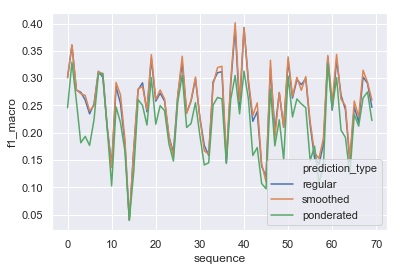

In [45]:
# f1_score
ax = sns.lineplot(x='sequence', y='f1_macro', hue='prediction_type', data=metrics_df)

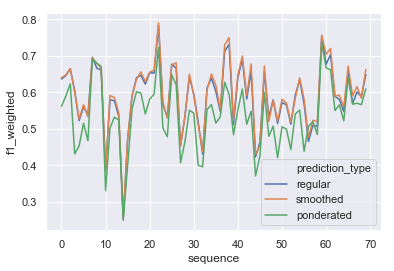

In [49]:
ax = sns.lineplot(x='sequence', y='f1_weighted', hue='prediction_type', data=metrics_df)

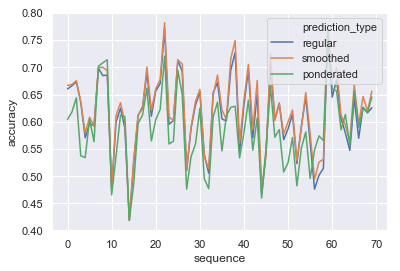

In [50]:
ax = sns.lineplot(x='sequence', y='accuracy', hue='prediction_type', data=metrics_df)

### todo
- afficher les scores par classe
- tester avec la focal loss et/ou en travaillant sur un dataset rééquilibré (online_step_1_balanced)